In [1]:
import pennylane as qml
from pennylane import numpy as np
from functools import reduce
import cirq
from tensorflow import keras

2023-11-13 11:41:07.178240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from pennylane.operation import Operation
from typing import Sequence, Type
import itertools
# class VariationalRotation(Operation):
#     ops = [qml.RX, qml.RY, qml.RZ]
    
#     def __init__(self, weights, wires, id=None):
#         super().__init__(weights, wires=wires, id=id)

#     @classmethod
#     def compute_decomposition(cls, weights, wires):
#         op_list = []
#         for i, op in enumerate(cls.ops):
#             op_list.append(op(weights[i], wires=wires))
#         return op_list

#     @classmethod
#     def shape(cls):
#         return (len(cls.ops),)
    


# class EncodingLayer(Operation):
#     """Parameterized encoding layer.
    
#     Implements `shape()` to determine parameter shapes.
#     """
#     operations = [qml.RX]
    
#     def __init__(self, weights, wires, id=None):
#         super().__init__(weights, wires=wires, id=id)

#     @classmethod
#     def compute_decomposition(cls, 
#         weights: np.tensor,
#         wires: list[int|str],
#         operations: list[Operation] = None,
#         ):
#         # Ensure weights have proper shape.
#         req_shape = cls.shape(wires, operations)
#         assert weights.numpy().shape == req_shape, f'encoder weights must have shape {req_shape}'
        
#         # Use default rotations for class instance if none were provided.
#         if operations is None: 
#             operations = cls.operations

#         # Decompose rotations into operations.
#         op_list = []
#         for i, wire in enumerate(wires):
#             for j, op in enumerate(operations):
#                 op_list.append(op(weights[i, j], wires=wire))

#         return op_list

#     @classmethod
#     def shape(cls, wires: list[int|str], operations: list[Operation] = None):
#         # Use default operations for class instance if none were provided.
#         if operations is None: 
#             operations = cls.operations
        
#         if isinstance(wires, (int, str)):
#             wires = [wires]
        
#         return (len(wires), len(operations),)


class ParameterizedOperation(Operation):
    """Performs a list of parameterized operations on each qubit.
    
    Implements `shape()` to determine parameter shapes.
    """
    operations = [] # Default is no operations, which will throw an error; users must override this or provide an operations list at runtime.
    
    def __init__(self, 
        weights: np.tensor,
        wires: list[int|str],
        id: str = None,
        operations: list[Operation] = None,
        ):
        self._hyperparameters = {"operations": operations or self.operations}
        super().__init__(weights, wires=wires, id=id)

    @classmethod
    def compute_decomposition(cls, 
        weights: np.tensor,
        wires: list[int|str],
        operations: list[Operation] = None,
        ):
        # Ensure weights have proper shape.
        req_shape = cls.shape(wires, operations)
        assert weights.numpy().shape == req_shape, f'parameters must have shape {req_shape}'
        
        # Use default rotations for class instance if none were provided.
        if operations is None: 
            operations = cls.operations

        # Decompose rotations into operations.
        op_list = []
        for i, wire in enumerate(wires):
            for j, op in enumerate(operations):
                op_list.append(op(weights[i, j], wires=wire))

        return op_list

    @classmethod
    def shape(cls, wires: list[int|str], operations: list[Operation] = None):

        # Use default operations for class instance if none were provided.
        if operations is None: 
            operations = cls.operations
        
        assert len(operations) > 0, 'at least one operation is required'
        
        if isinstance(wires, (int, str)):
            wires = [wires]
        
        return (len(wires), len(operations),)


class VariationalRotationLayer(ParameterizedOperation):
    """Parameterized variational rotation layer.
    
    Implements `shape()` to determine parameter shapes.
    """
    operations = [qml.RX, qml.RY, qml.RZ] # Default is 3 rotation sequence RX, RY, RZ.


class EncodingLayer(ParameterizedOperation):
    """Parameterized variational rotation layer.
    
    Implements `shape()` to determine parameter shapes.
    """
    operations = [qml.RX]
    

def circular_entangling_layer(
    wires: list[int|str],
    gate: Operation = qml.CZ,
    ) -> list[Operation]:
    """Entangles a list of qubits with their next-neighbor in circular fashion (i.e., ensures first and last qubit are also entangled)."""
    op_list = []
    for w0, w1 in zip(wires, wires[1:]):
        op_list.append(gate(wires=[w0, w1]))
    if len(wires) != 2:
        op_list.append(gate(wires=[wires[0], wires[-1]])) # Entangle the first and last qubit.
    return op_list

def unpack_operation_to_list(op: Operation | Sequence[Operation]) -> list[Operation]:
    # Single operation, so return list of size 1.
    if isinstance(op, Operation):
        return [op]
    # Sequence of operations, so convert to list and return.
    elif hasattr(op, '__iter__'):
        return list(itertools.chain.from_iterable(unpack_operation_to_list(o) for o in op))
    # Return operation as-is.
    else:
        raise ValueError(f'operation must be one of {{{Operation}, hasattr(__iter__)}} but received {type(op)}')


class VariationalEncodingPQC(Operation):
    _hyperparameters = {
        "variational_layer": VariationalRotationLayer,
        "encoding_layer": EncodingLayer,
        "entangling_layer": circular_entangling_layer,
    }
    
    def __init__(self,
        weights_var: np.tensor,
        weights_enc: np.tensor,
        n_layers: int,
        wires: list[int|str],
        variational_layer: Type[ParameterizedOperation] = None,
        encoding_layer: Type[ParameterizedOperation] = None,
        entangling_layer: Type[Operation] = None,
        id: str = None,
        ):
        self._hyperparameters = {
            "variational_layer": variational_layer or self._hyperparameters["variational_layer"],
            "encoding_layer": encoding_layer or self._hyperparameters["encoding_layer"],
            "entangling_layer": entangling_layer or self._hyperparameters["entangling_layer"],
        }
        super().__init__(weights_var, weights_enc, n_layers, wires=wires, id=id)

    @staticmethod
    def compute_decomposition(
        weights_var: np.tensor,
        weights_enc: np.tensor,
        n_layers: int,
        wires: list[int|str],
        variational_layer: Type[ParameterizedOperation],
        encoding_layer: Type[ParameterizedOperation],
        entangling_layer: Type[Operation],
        ):

        op_list = []
        for l in range(n_layers):
            # Variational layer.
            op_list.extend(unpack_operation_to_list(variational_layer(weights=weights_var[l], wires=wires)))
            op_list.extend(unpack_operation_to_list(entangling_layer(wires=wires)))
            
            # Encoding layer.
            op_list.extend(unpack_operation_to_list(encoding_layer(weights=weights_enc[l], wires=wires)))

        # Last variational layer at the end.
        op_list.extend(unpack_operation_to_list(variational_layer(weights=weights_var[l], wires=wires)))

        return op_list

    @classmethod
    def shape(cls,
        n_layers: int,
        wires: list[int|str],
        variational_layer: Type[ParameterizedOperation] = None,
        encoding_layer: Type[ParameterizedOperation] = None,
        ):
        """Returns tuple of (shape_var, shape_enc)."""

        # Compute shape for single variational layer.
        shape_var = (variational_layer or cls._hyperparameters["variational_layer"]).shape(wires)

        # Compute shape for all variational layers.
        shape_var = (n_layers + 1, *shape_var) # +1 because there is one additional variational layer at the end.

        # Compute shape for single encoding layer.
        shape_enc = (encoding_layer or cls._hyperparameters["encoding_layer"]).shape(wires)
        
        # Compute shape for all encoding layers.
        shape_enc = (n_layers, *shape_enc)
        
        return shape_var, shape_enc


wires = list(range(3))
dev = qml.device('default.qubit', wires=len(wires))

def circuit(inputs, weights_var, weights_enc):

    # for w in wires:
    #     weights = np.random.random(size=VariationalRotation.shape())
    #     VariationalRotation(weights=weights, wires=w)
    #     VariationalRotation(weights=weights, wires=w)
    
    # shape_enc = EncodingLayer.shape(wires=wires, operations=[qml.RX, qml.RY])
    # weights_enc = np.random.random(size=shape_enc)
    # EncodingLayer(weights_enc, wires, operations=[qml.RX, qml.RY])
    # # EncodingLayer.compute_decomposition(weights_enc, wires, operations=[qml.RX, qml.RY])
    # print(weights_enc)
    
    # shape_var = VariationalRotationLayer.shape(wires=wires)
    # weights_var = np.random.random(size=shape_var)
    # VariationalRotationLayer(weights_var, wires)
    # # EncodingLayer.compute_decomposition(weights_var, wires, operations=[qml.RX, qml.RY])
    # print(weights_var)
    
    # shape_var, shape_enc = VariationalEncodingPQC.shape(n_layers=1, wires=wires)
    # weights_var = np.random.random(size=shape_var)
    # weights_enc = np.random.random(size=shape_enc)
    # shape_var, shape_enc
    VariationalEncodingPQC(weights_var=weights_var, weights_enc=weights_enc, n_layers=1, wires=wires)
    # VariationalEncodingPQC.decomposition()
    # op.decomposition()
        
        
    return [qml.expval(qml.PauliZ(wires=w)) for w in wires]

qnode = qml.QNode(func=circuit, device=dev, interface='tf')
# print(qml.draw(qnode, wire_order=wires)(wires))
# # # qnode(range(3))


shape_var, shape_enc = VariationalEncodingPQC.shape(n_layers=1, wires=wires)
# weights_var = np.random.random(size=shape_var)
# weights_enc = np.random.random(size=shape_enc)

weight_shapes = {
    'weights_var': shape_var,
    'weights_enc': shape_enc,
}
qlayer = qml.qnn.KerasLayer(qnode=qnode, weight_shapes=weight_shapes, output_dim=len(wires))
qlayer

inp = keras.Input(shape=(2,))
model = keras.Sequential([inp, keras.layers.Dense(2), qlayer, keras.layers.Dense(2, activation='softmax')])
model.summary()

# qnode(wires)
# qnode(wires)

# qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2)(wires)

# shape_var, shape_enc = VariationalEncodingPQC.shape(n_layers=1, wires=wires)
# weights_var = np.random.random(size=shape_var)
# weights_enc = np.random.random(size=shape_enc)
# op = VariationalEncodingPQC(weights_var=weights_var, weights_enc=weights_enc, n_layers=1, wires=wires)
# op = circular_entangling_layer(wires)
# unpack_operation_to_list([op, 3])
# hasattr(op, '__iter__')
# # dev.stopping_condition(op)
# op.decomposition()

# shape_var = VariationalRotationLayer.shape(wires=wires)
# shape_enc = EncodingLayer.shape(wires=wires, operations=[qml.RX, qml.RY])
# shape_var, shape_enc

# shape_var, shape_enc = VariationalEncodingPQC.shape(n_layers=1, wires=wires)
# shape_var, shape_enc

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 6         
                                                                 
 keras_layer (KerasLayer)    (None, 3)                 21        
                                                                 
 dense_1 (Dense)             (None, 2)                 8         
                                                                 
Total params: 35 (140.00 Byte)
Trainable params: 35 (140.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


agents_var_thetas.shape=(3, 2, 2, 4, 3)
agents_enc_inputs.shape=(3, 2, 1, 4)
var_thetas.shape=(3, 2, 4, 3)
enc_inputs.shape=(3, 1, 4)
phi.shape (3, 4, 3)
single_rotation_encoding_layer: phi.shape=(3, 4)
phi.shape (3, 4, 3)
var_thetas.shape=(3, 2, 4, 3)
enc_inputs.shape=(3, 1, 4)
phi.shape (3, 4, 3)
single_rotation_encoding_layer: phi.shape=(3, 4)
phi.shape (3, 4, 3)


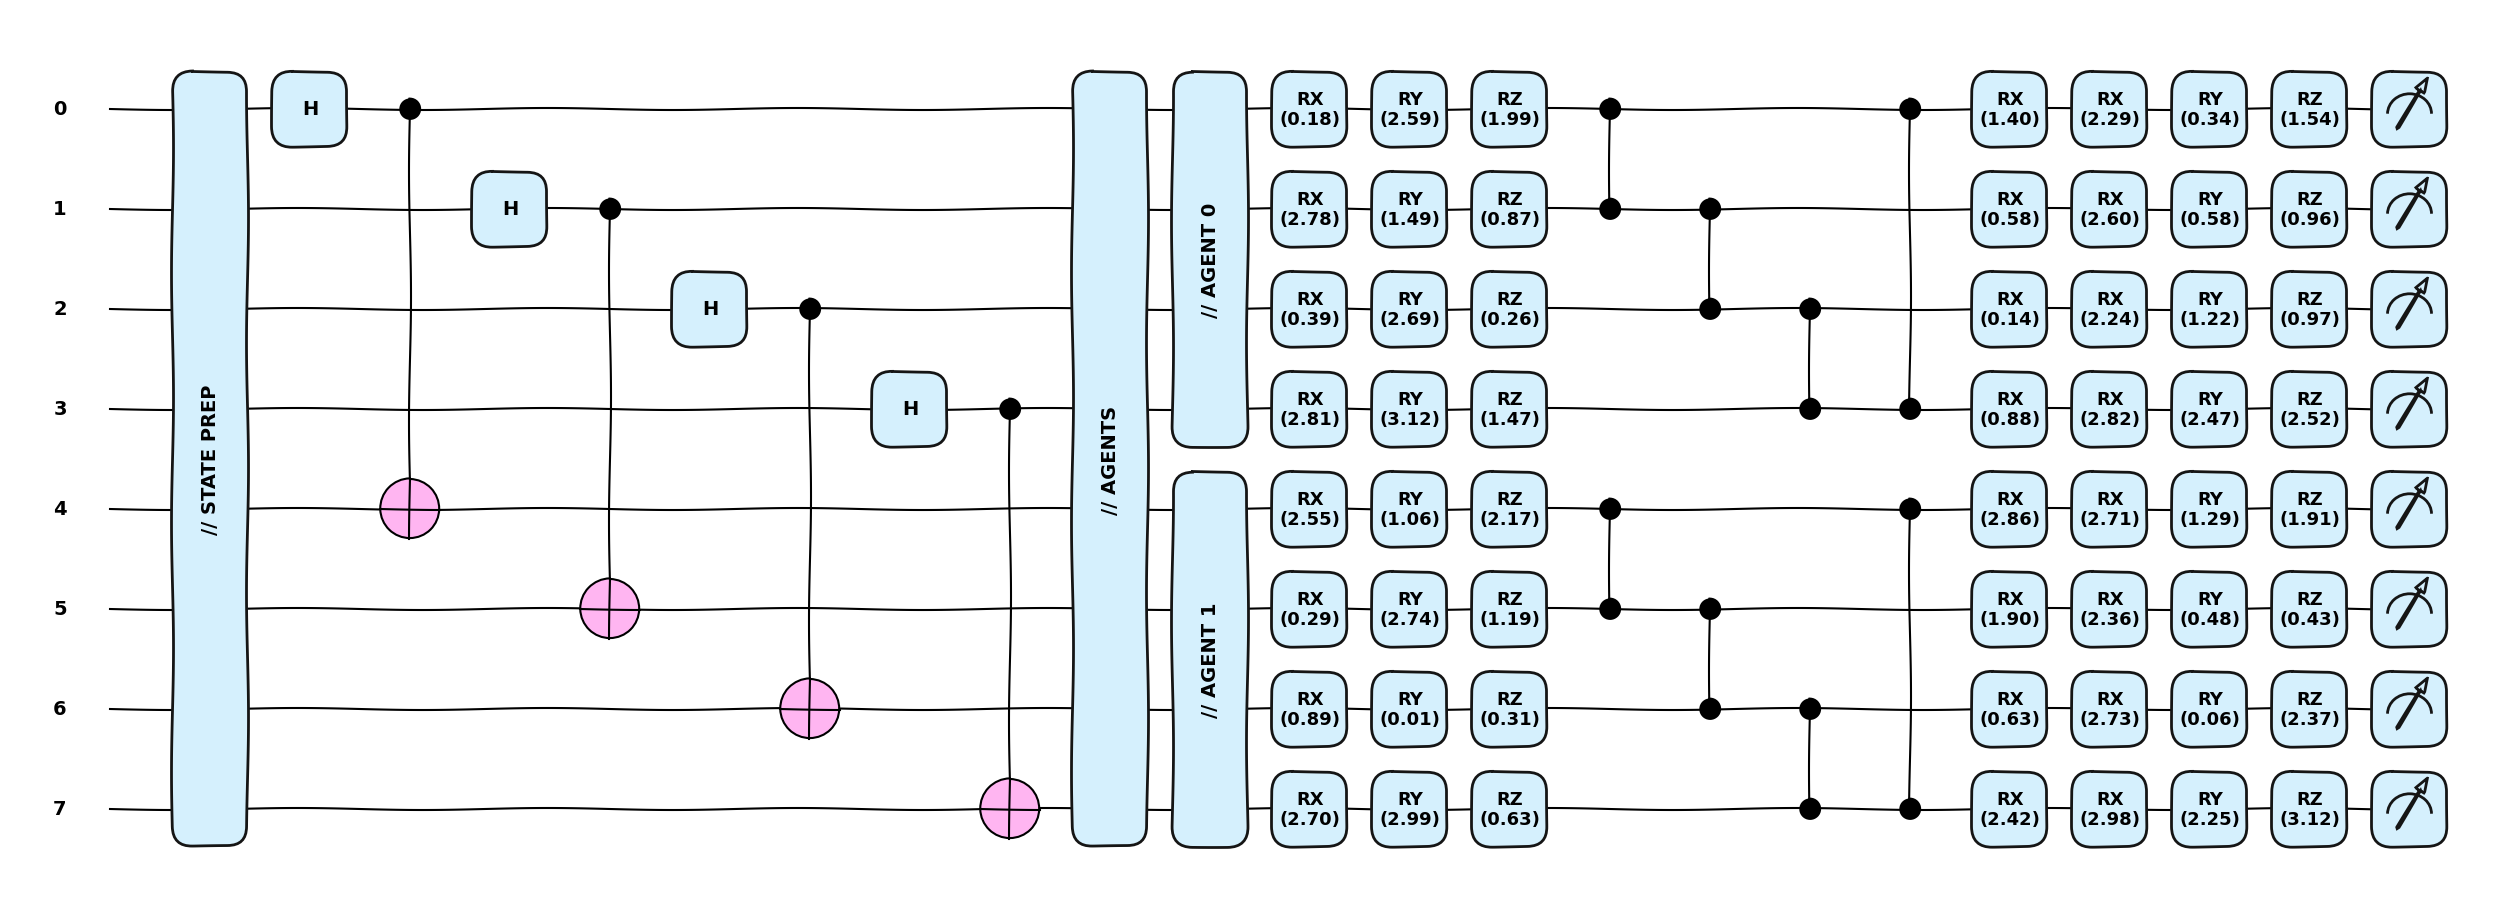

In [39]:
def variational_rotation_layer(
    wires: list[int],
    phi: np.ndarray,
    ):
    print('phi.shape', phi.shape)
    for i, wire in enumerate(wires):
        qml.RX(phi=phi[..., i, 0], wires=wire)
        qml.RY(phi=phi[..., i, 1], wires=wire)
        qml.RZ(phi=phi[..., i, 2], wires=wire)


def circular_entangling_layer(
    wires: list[int],
    ):
    """Entangles a list of qubits with their next-neighbor in circular fashion (i.e., ensures first and last qubit are also entangled)."""
    for w0, w1 in zip(wires, wires[1:]):
        qml.CZ(wires=[w0, w1])
    if len(wires) != 2:
        qml.CZ(wires=[wires[0], wires[-1]]) # Entangle the first and last qubit.


def single_rotation_encoding_layer(
    wires: list[int],
    phi: np.ndarray,
    ):
    
    print(f"single_rotation_encoding_layer: {phi.shape=}")
    for i, wire in enumerate(wires):
        qml.RX(phi=phi[..., i], wires=wire)


def variational_encoding_pqc(
    wires: list[int],
    n_layers: int,
    var_thetas: np.ndarray,
    enc_inputs: np.ndarray,
    ):
    n_var_rotations = 3
    n_wires = len(wires)
    d = n_wires
    
    print(f"{var_thetas.shape=}")
    var_thetas = np.asarray(var_thetas)
    # assert var_thetas.shape == (n_layers+1, d, n_var_rotations), "var_thetas must have shape (n_layers+1, d, n_var_rotations)"
    
    print(f"{enc_inputs.shape=}")
    enc_inputs = np.asarray(enc_inputs)
    # assert enc_inputs.shape == (n_layers, d), "enc_inputs must have shape (n_layers, d)"
    
    for l in range(n_layers):
        variational_rotation_layer(wires, var_thetas[..., l, :, :])
        circular_entangling_layer(wires)
        single_rotation_encoding_layer(wires, enc_inputs[..., l, :])
    variational_rotation_layer(wires, var_thetas[..., n_layers, :, :])


## Functions to create various entangled input states.


def entangle_agents_phi_plus(wires: list[int], d: int, n: int):
    """Entangles via $\\Phi^+$."""
    for i in range(d):
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


def entangle_agents_phi_minus(wires: list[int], d: int, n: int):
    """Entangles via $\\Phi^-$."""
    for i in range(d):
        qml.PauliX(wires=wires[i])
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


def entangle_agents_psi_plus(wires: list[int], d: int, n: int):
    """Entangles via $\\Psi^+$."""
    for i in range(d):
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.PauliX(wires=wires[(j+1)*d + i])
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])
            

def entangle_agents_psi_minus(wires: list[int], d: int, n: int):
    """Entangles via $\\Psi^-$."""
    for i in range(d):
        qml.PauliX(wires=wires[i])
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.PauliX(wires=wires[(j+1)*d + i])
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


def TensorPauliZ(wires, n, d) -> list:
    all_obs = []
    for aidx in range(n):
        qidx = aidx * d # Starting qubit index for the specified agent.
        ops = [qml.PauliZ(w) for w in wires[qidx:qidx+d]]
        obs = reduce((lambda a, b: a @ b), ops)
        all_obs.append(obs)
        all_obs.append(-obs)
    return all_obs


def IndividualPauliZ(wires) -> list:
    all_obs = []
    for w in wires:
        obs = qml.PauliZ(w)
        all_obs.append(obs)
    return all_obs



class AnnotationGate(qml.Identity):
    """This gate behaves like the Identity, but allows users to modify the string label of the gate when printed or drawn."""
    
    def __init__(self, annotation: str, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.annotation = annotation
    
    def label(self, decimals=None, base_label=None, cache=None):
        return base_label or self.annotation

# dev = qml.device('default.qubit', wires=len(wires))

# @qml.batch_params
# @qml.qnode(dev)
def circuit(
    wires: list,
    d: int, # qubit dimensions for each agent
    n: int, # number of agents
    n_layers: int,
    agents_var_thetas: np.ndarray,
    agents_enc_inputs: np.ndarray,
    initial_state_vector: str|np.ndarray = None,
    obs_func = lambda wires: TensorPauliZ(wires, n, d),
    annotations: bool = False,
    ):
    # n_wires = len(wires)
    
    # for w in wires:
    #     # qml.Hadamard(wires=w)
    #     qml.RX()
    
    # Variational parameters.
    # symbol_superscript_index = None
    n_var_rotations = 3
    
    ########
    agents_var_thetas = np.asarray(agents_var_thetas)
    # assert agents_var_thetas.shape == (n, n_layers+1, d, n_var_rotations), "agents_var_thetas must have shape (n, n_layers+1, d, n_var_rotations)"
    
    agents_enc_inputs = np.asarray(agents_enc_inputs)
    # assert agents_enc_inputs.shape == (n, n_layers, d), "agents_enc_inputs must have shape (n, n_layers, d)"
    ########
    
    # var_thetas = sympy.symbols(f"theta{f'^{{({symbol_superscript_index})}}' if symbol_superscript_index is not None else ''}(0:{n_var_rotations*(n_layers+1)*d})") # Add +1 here because there will be a final variational layer at the end.
    # var_thetas = np.asarray(var_thetas).reshape((n_layers+1, d, n_var_rotations))
    
    
    # for l in range(n_layers):
    #     variational_rotation_layer(wires, var_thetas[l])
    #     circular_entangling_layer(wires)
    #     single_rotation_encoding_layer(wires, enc_inputs[l])
    # variational_rotation_layer(wires, var_thetas[n_layers])
    
    measurements = []
    
    # entangle_agents_phi_plus(wires, d, n)
    
    if annotations: AnnotationGate('// STATE PREP', wires=wires)
    
    # Prepare initial state.
    if isinstance(initial_state_vector, str):
        match initial_state_vector:
            case 'phi+':
                entangle_agents_phi_plus(wires, d, n)
            case 'phi-':
                entangle_agents_phi_minus(wires, d, n)
            case 'psi+':
                entangle_agents_psi_plus(wires, d, n)
            case 'psi-':
                entangle_agents_psi_minus(wires, d, n)

    elif initial_state_vector is not None:
        qml.QubitStateVector(initial_state_vector, wires=wires)

    # qml.operation.Operator(wires=wires, id='mynaem', name='MYNAME')
    
    # Annotate all wires to add visual separation.
    if annotations: AnnotationGate(f'// AGENTS', wires=wires)
    
    for aidx in range(n):
        qidx = aidx * d # Starting qubit index for the specified agent.
        if annotations: AnnotationGate(f'// AGENT {aidx}', wires=wires[qidx:qidx+d])
        variational_encoding_pqc(
            wires[qidx:qidx+d],
            n_layers,
            agents_var_thetas[..., aidx, :, :, :],
            agents_enc_inputs[..., aidx, :, :],
            )
    
    # for aidx in range(n):
    #     qidx = aidx * d # Starting qubit index for the specified agent.
    #     ops = [qml.PauliZ(w) for w in wires[qidx:qidx+d]]
    #     obs = reduce((lambda a, b: a @ b), ops)
    #     measurements.append(qml.expval(obs))
    #     measurements.append(qml.expval(-obs))
    obs = obs_func(wires)
    for o in obs:
        measurements.append(qml.expval(o))
    
    # return qml.expval(obs), qml.expval(-obs), qml.state()
    # return np.asarray(measurements)
    return np.asarray(measurements)
    # return *measurements, qml.state()
    # return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)), qml.expval(-(qml.PauliZ(0) @ qml.PauliZ(1))), qml.state()
    # return qml.expval(obs), qml.expval(reduce(lambda a, b: a @ b, [qml.PauliX(w) for w in wires])), qml.state()


n = 2
d = 4
wires = list(range(n * d))

n_layers = 1
batch_size=3
agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(batch_size, n, n_layers+1, d, 3))
agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(batch_size, n, n_layers, d))
print(f"{agents_var_thetas.shape=}")
print(f"{agents_enc_inputs.shape=}")

# qnode = circuit

dev = qml.device('default.qubit', wires=len(wires))
qnode = qml.QNode(func=circuit, device=dev)
qnode = qml.batch_params(qnode) # Enable batched inputs (first dimension of parameters indicates batches).
# qnode = qml.batch_input(qnode, argnum=0)

fig, ax = qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector='phi+', annotations=True)
# print(qml.draw(qnode, wire_order=wires)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, obs_func=IndividualPauliZ))

var_thetas.shape=(2, 3, 3)
enc_inputs.shape=(1, 3)
phi.shape (3, 3)
single_rotation_encoding_layer: phi.shape=(3,)
phi.shape (3, 3)
var_thetas.shape=(2, 3, 3)
enc_inputs.shape=(1, 3)
phi.shape (3, 3)
single_rotation_encoding_layer: phi.shape=(3,)
phi.shape (3, 3)
var_thetas.shape=(2, 3, 3)
enc_inputs.shape=(1, 3)
phi.shape (3, 3)
single_rotation_encoding_layer: phi.shape=(3,)
phi.shape (3, 3)


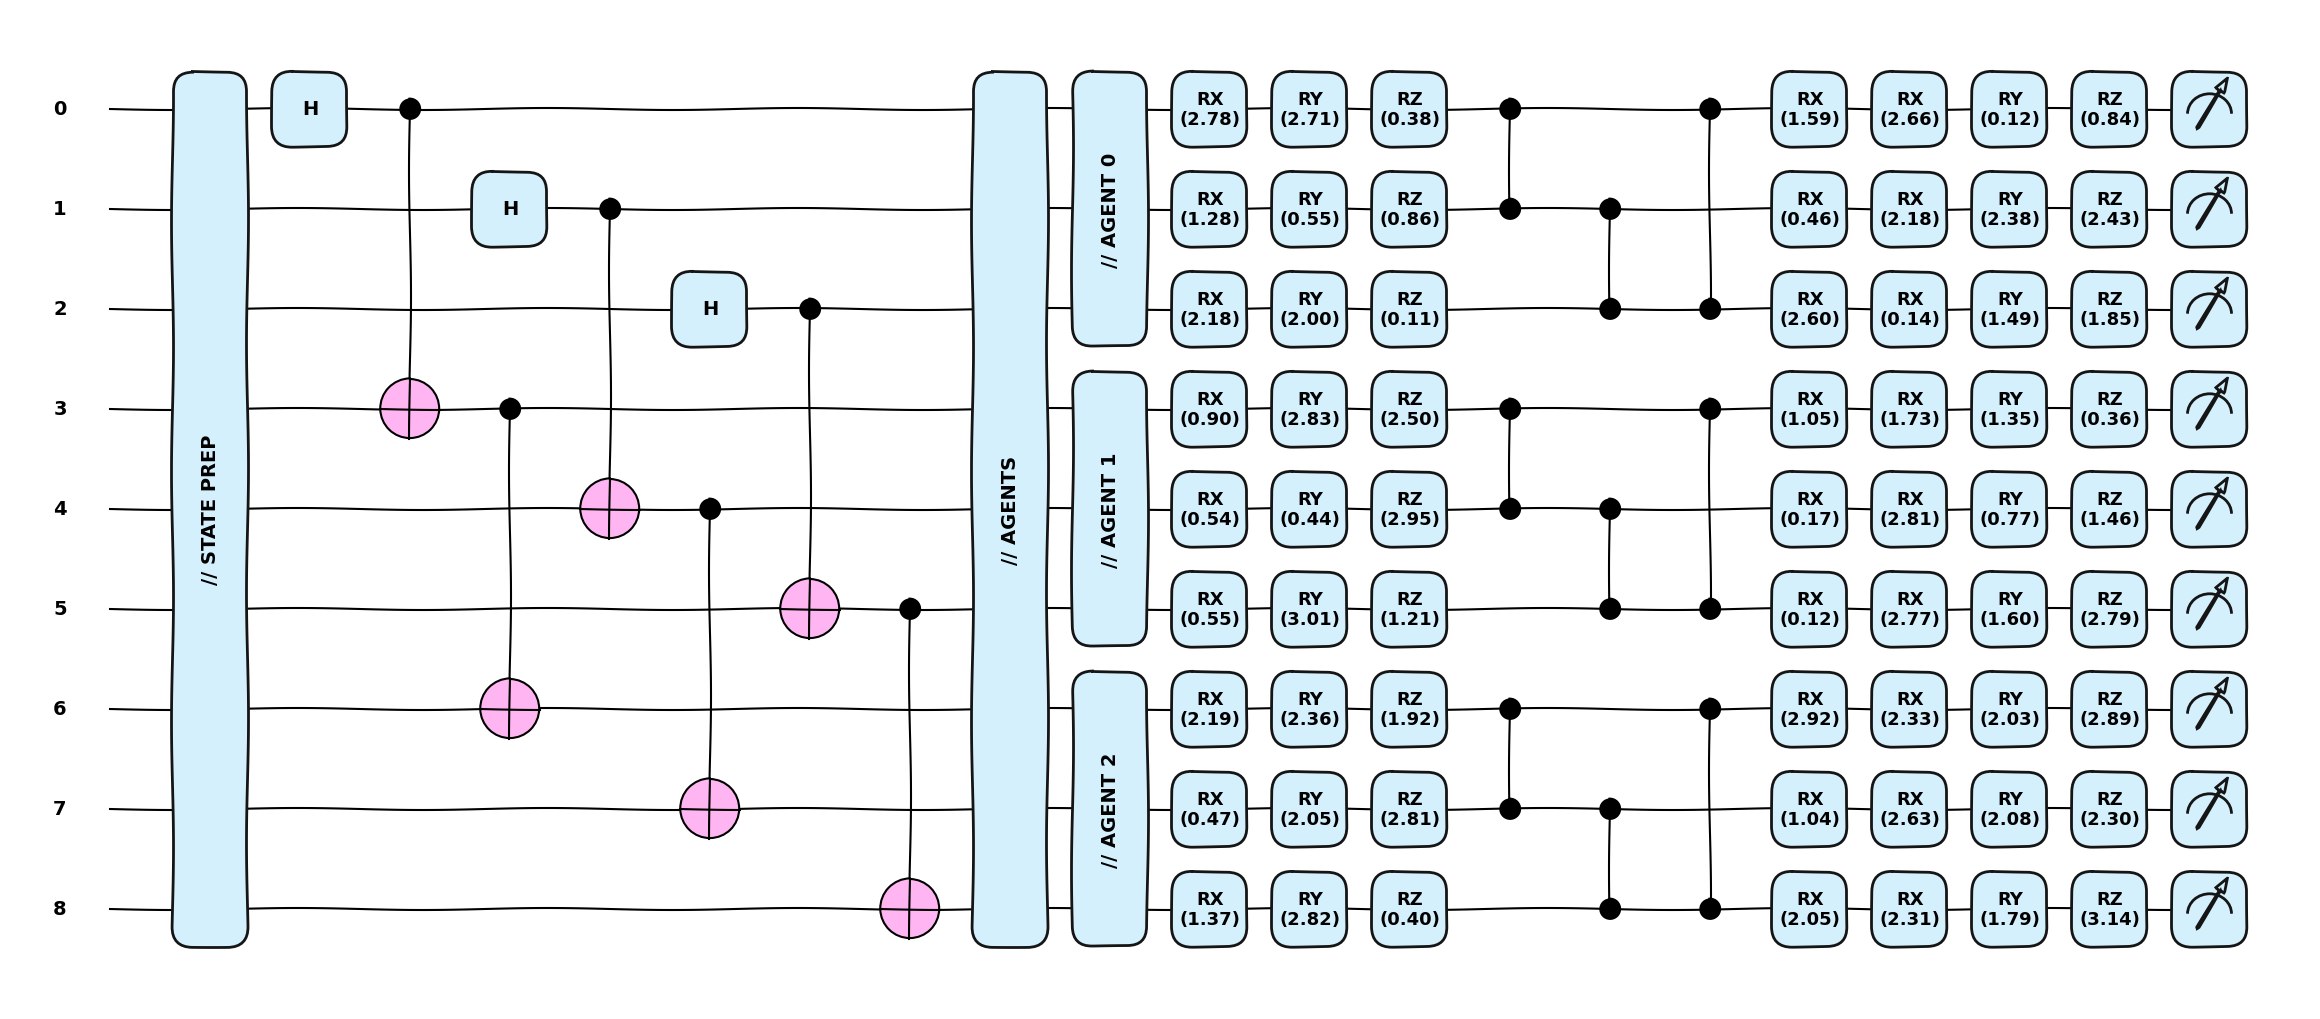

In [40]:
n = 3
d = 3
wires = list(range(n * d))

n_layers = 1
agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(n, n_layers+1, d, 3))
agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(n, n_layers, d))


dev = qml.device('default.qubit', wires=len(wires))
qnode = qml.QNode(func=circuit, device=dev)

fig, ax = qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector='phi+', annotations=True)

In [41]:
print(qml.draw(qnode, wire_order=wires)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, obs_func=IndividualPauliZ, initial_state_vector='phi+', annotations=True))

var_thetas.shape=(2, 3, 3)
enc_inputs.shape=(1, 3)
phi.shape (3, 3)
single_rotation_encoding_layer: phi.shape=(3,)
phi.shape (3, 3)
var_thetas.shape=(2, 3, 3)
enc_inputs.shape=(1, 3)
phi.shape (3, 3)
single_rotation_encoding_layer: phi.shape=(3,)
phi.shape (3, 3)
var_thetas.shape=(2, 3, 3)
enc_inputs.shape=(1, 3)
phi.shape (3, 3)
single_rotation_encoding_layer: phi.shape=(3,)
phi.shape (3, 3)
0: ─╭// STATE PREP──H─╭●────────────────╭// AGENTS─╭// AGENT 0──RX(2.78)──RY(2.71)──RZ(0.38)─╭●───
1: ─├// STATE PREP────│───H─╭●──────────├// AGENTS─├// AGENT 0──RX(1.28)──RY(0.55)──RZ(0.86)─╰Z─╭●
2: ─├// STATE PREP────│─────│───H─╭●────├// AGENTS─╰// AGENT 0──RX(2.18)──RY(2.00)──RZ(0.11)────╰Z
3: ─├// STATE PREP────╰X─╭●─│─────│─────├// AGENTS─╭// AGENT 1──RX(0.90)──RY(2.83)──RZ(2.50)─╭●───
4: ─├// STATE PREP───────│──╰X─╭●─│─────├// AGENTS─├// AGENT 1──RX(0.54)──RY(0.44)──RZ(2.95)─╰Z─╭●
5: ─├// STATE PREP───────│─────│──╰X─╭●─├// AGENTS─╰// AGENT 1──RX(0.55)──RY(3.01)──RZ(1.21)────╰Z
6: ─├// ST

In [8]:
def softmax(x, axis=None):
    return np.exp(x)/np.sum(np.exp(x), axis=axis)

In [47]:
agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(n, n_layers+1, d, 3))
agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(n, n_layers, d))


meas = qnode(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, obs_func=IndividualPauliZ)
meas = meas.reshape((-1, n, d)) # Reshape to 2D with (n_agents, d_qubits) because each agent only has 1 observation per qubit.

meas.shape, meas, np.asarray(meas >= 0, dtype=int)

var_thetas.shape=(2, 3, 3)
enc_inputs.shape=(1, 3)
phi.shape (3, 3)
single_rotation_encoding_layer: phi.shape=(3,)
phi.shape (3, 3)
var_thetas.shape=(2, 3, 3)
enc_inputs.shape=(1, 3)
phi.shape (3, 3)
single_rotation_encoding_layer: phi.shape=(3,)
phi.shape (3, 3)
var_thetas.shape=(2, 3, 3)
enc_inputs.shape=(1, 3)
phi.shape (3, 3)
single_rotation_encoding_layer: phi.shape=(3,)
phi.shape (3, 3)


((1, 3, 3),
 tensor([[[ 0.01359445, -0.11338253, -0.02047639],
          [ 0.61890064,  0.03981027,  0.35736239],
          [-0.02513233, -0.31289611, -0.05858133]]], requires_grad=True),
 tensor([[[1, 0, 0],
          [1, 1, 1],
          [0, 0, 0]]], requires_grad=True))

In [10]:
meas = qnode(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs)
meas = meas.reshape((n, 2)) # Reshape to 2D with (n_agents, 2)
# meas = np.asarray(meas)
# np.concatenate(meas).reshape((n, 2))

meas, softmax(meas)

(tensor([[ 0.19314022, -0.19314022],
         [ 0.10244318, -0.10244318],
         [-0.19591157,  0.19591157]], requires_grad=True),
 tensor([[0.19930459, 0.13544339],
         [0.18202375, 0.14830202],
         [0.13506855, 0.1998577 ]], requires_grad=True))

In [11]:
# Compute matrix representation for entire circuit.
U = qml.matrix(qnode, wire_order=wires)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs)
U.shape # for 8 qubits is (256, 256)

(512, 512)

In [12]:
eig_vals, eig_vects = cirq.unitary_eig(U) # eig_vects is a matrix with eigenvectors as columns.
eig_vects.shape

(512, 512)

In [13]:
initial_state_vector = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]
initial_state_vector

array([ 2.76605241e-03+8.04015055e-04j,  9.93102235e-04+4.64281833e-03j,
       -6.36465527e-03+5.89538254e-03j,  7.72893429e-03-7.38305647e-03j,
        5.81551742e-03+1.21013388e-03j, -1.76524780e-03+1.59234701e-03j,
       -1.30450493e-02-4.86550541e-03j, -4.91120967e-03-4.24368182e-03j,
        4.33799074e-03+6.34101463e-03j, -5.81626319e-03+1.12485728e-02j,
       -2.30985007e-02+1.36920218e-03j,  2.84290367e-02-2.12422534e-03j,
        9.93380330e-03+1.23421028e-02j, -6.33401558e-03+2.91667770e-04j,
       -1.86402505e-02-3.21173683e-02j, -2.93312769e-03-1.70614360e-02j,
        5.10368090e-03-8.28814990e-03j,  1.60159451e-02+9.35420495e-04j,
        1.34870113e-02+2.60282878e-02j, -1.71076097e-02-3.18087085e-02j,
        9.16579944e-03-1.78569226e-02j,  3.60139699e-03+7.18059136e-03j,
       -2.75670554e-02+3.81235237e-02j, -1.82352223e-02+1.21862613e-02j,
        8.89417426e-04+2.62770155e-02j, -3.74465303e-02+2.18118573e-02j,
       -6.92266055e-02-3.84452065e-02j,  8.60082308

(tensor([[ 2.59547327e-03, -2.59547327e-03],
         [ 3.35141228e-01, -3.35141228e-01],
         [ 7.43849426e-15, -7.43849426e-15]], requires_grad=True),
 tensor([[0.1640007 , 0.16315158],
         [0.22870122, 0.11699532],
         [0.16357559, 0.16357559]], requires_grad=True))

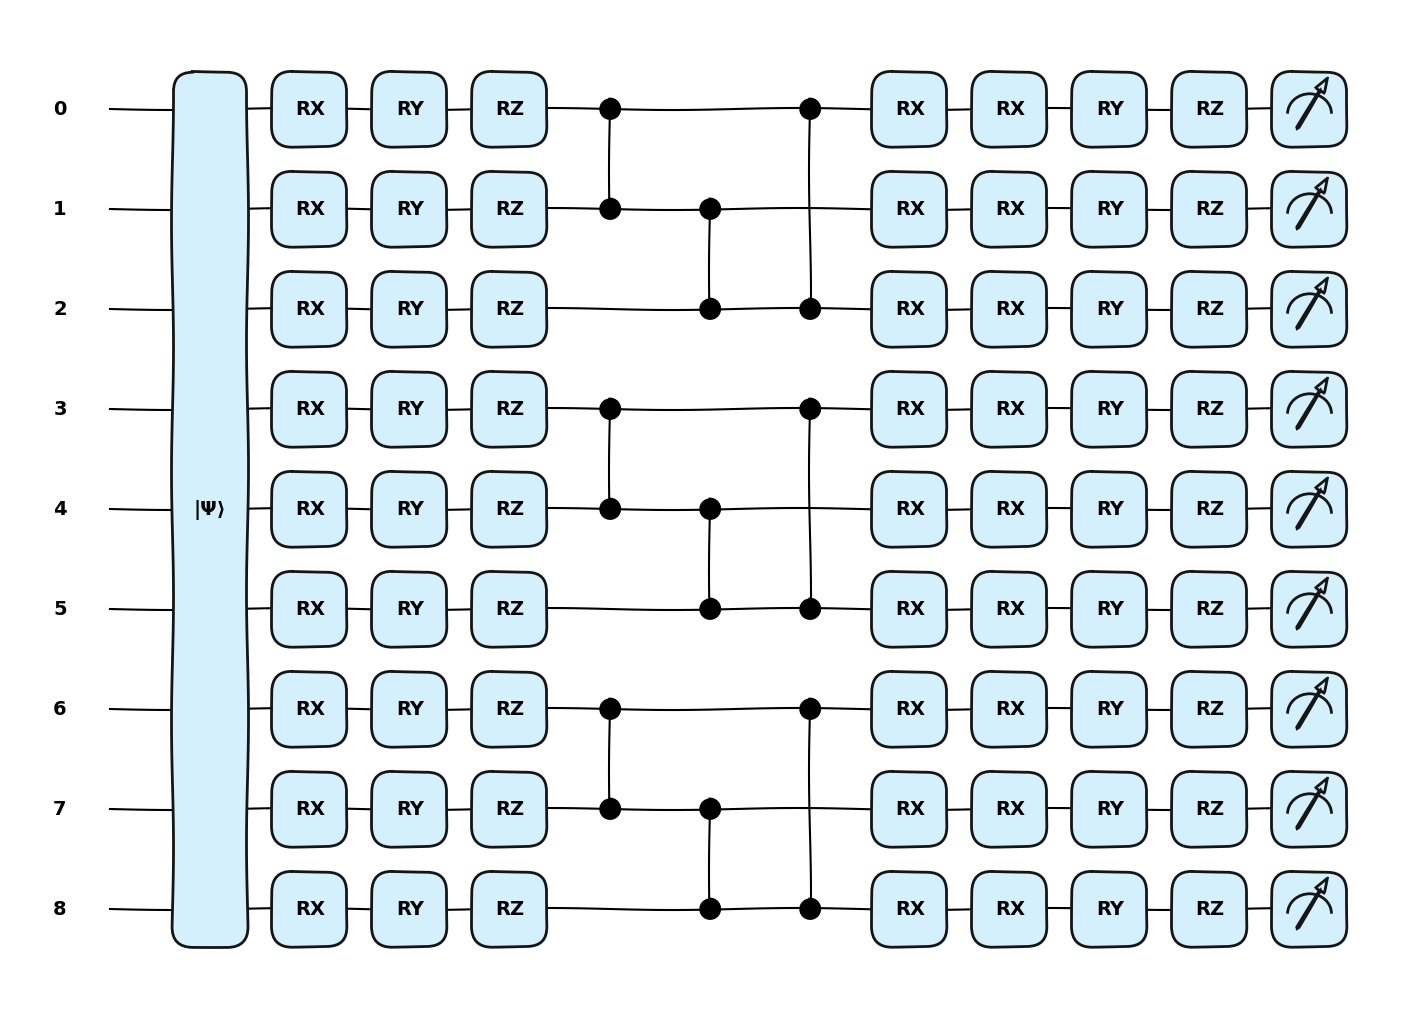

In [14]:
qml.draw_mpl(qnode, wire_order=wires, style="pennylane")(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector)
meas = qnode(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector)
meas = meas.reshape((n, 2)) # Reshape to 2D with (n_agents, 2)

meas, softmax(meas)

In [18]:
batch_size = 3
tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(batch_size, n, n_layers+1, d, 3))
tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(batch_size, n, n_layers, d))
meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state_vector)
meas.shape

AssertionError: agents_var_thetas must have shape (n, n_layers+1, d, n_var_rotations)

In [15]:
def experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=100):
    history = []
    for i in range(n_runs):
        tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(n, n_layers+1, d, 3))
        tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(n, n_layers, d))
        meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state_vector)
        meas = meas.reshape((n, 2)) # Reshape to 2D with (n_agents, 2)

        # meas, softmax(meas), np.argmax(softmax(meas), axis=1)
        
        history.append(np.argmax(softmax(meas), axis=1))

    # Determine how many times each row of actions occurred.
    return np.unique(np.asarray(history), axis=0, return_counts=True)

In [17]:
# Initial state is all zeros (default |0>).
initial_state_vector = None
experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([141, 143, 118, 135, 122, 103, 113, 125]))

In [23]:
# Create the desired starting state.
# In this case, an equal superposition of the first and last eigenvector.
initial_state_vector = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([259, 238, 254, 249]))

In [24]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([267, 283, 228, 222]))

In [25]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'phi+'

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([635, 137, 180,  48]))

In [26]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'phi-'

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([634, 135, 192,  39]))

In [27]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'psi+'

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([624, 148, 184,  44]))

In [28]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'psi-'

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([614, 131, 208,  47]))

In [46]:
def experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=100):
    history = []
    for i in range(n_runs):
        tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(n, n_layers+1, d, 3))
        tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(n, n_layers, d))
        meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state_vector, obs_func=IndividualPauliZ)
        meas = meas.reshape((n, d)) # Reshape to 2D with (n_agents, d_qubits)
        
        history.append(np.asarray(meas >= 0, dtype=int))

    # Determine how many times each row of actions occurred.
    return np.unique(np.asarray(history), axis=0, return_counts=True)

In [52]:
initial_state_vector = None

states, counts = experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)
states, counts

(array([[[0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 1]],
 
        [[0, 0, 0, 0],
         [0, 0, 1, 0]],
 
        ...,
 
        [[1, 1, 1, 1],
         [1, 1, 0, 1]],
 
        [[1, 1, 1, 1],
         [1, 1, 1, 0]],
 
        [[1, 1, 1, 1],
         [1, 1, 1, 1]]]),
 array([ 8,  4,  4,  3,  6,  2,  6,  4,  7,  1,  1,  2,  5,  2,  1,  4,  3,
         3,  5,  3,  5,  4,  3,  4, 10,  6,  7,  3,  2,  6,  4,  3,  5,  3,
         7,  2,  5,  2,  4,  2,  7,  1,  3,  1,  5,  7,  2,  3,  5,  2,  4,
         3,  6,  5,  1,  7,  4,  3,  4,  3,  6,  4,  2,  3,  3,  3,  6,  5,
         4,  4,  1,  5,  9,  1,  2,  5,  6,  3,  3,  2,  2,  6,  2,  2,  1,
         3,  4,  5,  1,  5,  7,  3,  1,  1,  3,  4,  6,  9,  3,  2,  1,  4,
         2,  2,  3,  5,  6,  4,  6,  3,  3,  6,  3,  3,  1,  1,  8,  9,  5,
         4,  2,  5,  5,  5,  5,  5,  6,  2,  4,  1,  2,  3,  2,  5,  6,  3,
         7,  3,  8,  7,  1,  2,  2,  3,  2,  1,  5,  2,  3,  3,  3,  4,  3,
       

In [54]:
initial_state_vector = 'phi+'

states, counts = experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

In [58]:
states[-10:]

array([[[1, 1, 1, 1],
        [0, 1, 1, 0]],

       [[1, 1, 1, 1],
        [0, 1, 1, 1]],

       [[1, 1, 1, 1],
        [1, 0, 0, 0]],

       [[1, 1, 1, 1],
        [1, 0, 0, 1]],

       [[1, 1, 1, 1],
        [1, 0, 1, 0]],

       [[1, 1, 1, 1],
        [1, 0, 1, 1]],

       [[1, 1, 1, 1],
        [1, 1, 0, 0]],

       [[1, 1, 1, 1],
        [1, 1, 0, 1]],

       [[1, 1, 1, 1],
        [1, 1, 1, 0]],

       [[1, 1, 1, 1],
        [1, 1, 1, 1]]])

In [59]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.
states, counts = experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=1000)

In [60]:
counts

array([ 8,  5,  5,  3,  4,  7,  2,  3,  6,  5,  5,  4,  5,  4,  4,  3,  9,
        1,  4,  4,  8,  6,  3,  5,  2,  2,  3,  4,  5,  5,  5,  3,  7,  6,
        3,  2,  5,  5,  1,  3,  5,  3,  5,  5,  2,  9,  1,  4,  7, 10,  5,
        4,  5,  6,  5,  6,  4,  3,  3,  3,  3,  4,  2,  1,  3,  7,  3,  3,
        2,  2,  3,  4,  1,  4,  5,  3,  4,  1,  4,  4,  3,  4,  1,  2,  3,
        2,  8,  2,  6,  2,  5,  1,  3,  1,  9,  3,  3,  5,  2,  2,  2,  3,
        3,  2,  1,  1,  5,  3,  8,  4,  2,  4,  5,  3,  3,  2,  1,  5,  1,
        3,  3,  2,  1,  1,  4,  1,  4,  4,  4,  5,  1,  3,  7,  3,  7,  3,
        1, 11,  5,  1,  9, 10,  8,  1,  5,  4,  3,  7,  3,  7,  6,  6,  1,
        3,  3,  4,  7,  2,  7,  9,  2,  5,  5,  6,  6,  3,  7,  2,  3,  6,
        6,  3,  7,  6,  3,  2, 10,  3,  6,  8,  3,  2,  2,  3,  3,  5,  4,
        6,  4,  3,  5,  2,  9,  3,  2,  2,  4,  4,  2,  2,  3,  1,  3,  2,
        4,  4,  3,  2,  6,  3,  1,  4,  6,  5,  2,  5,  7,  2,  2,  5,  3,
        2,  4,  2,  3,  5

In [70]:
idx = np.all(states[:,0,:] == states[:,1,:], axis=1)
states[idx], counts[idx]

(array([[[0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 1],
         [0, 0, 0, 1]],
 
        [[0, 0, 1, 0],
         [0, 0, 1, 0]],
 
        [[0, 0, 1, 1],
         [0, 0, 1, 1]],
 
        [[0, 1, 0, 0],
         [0, 1, 0, 0]],
 
        [[0, 1, 0, 1],
         [0, 1, 0, 1]],
 
        [[0, 1, 1, 0],
         [0, 1, 1, 0]],
 
        [[0, 1, 1, 1],
         [0, 1, 1, 1]],
 
        [[1, 0, 0, 0],
         [1, 0, 0, 0]],
 
        [[1, 0, 0, 1],
         [1, 0, 0, 1]],
 
        [[1, 0, 1, 0],
         [1, 0, 1, 0]],
 
        [[1, 0, 1, 1],
         [1, 0, 1, 1]],
 
        [[1, 1, 0, 0],
         [1, 1, 0, 0]],
 
        [[1, 1, 0, 1],
         [1, 1, 0, 1]],
 
        [[1, 1, 1, 0],
         [1, 1, 1, 0]],
 
        [[1, 1, 1, 1],
         [1, 1, 1, 1]]]),
 array([8, 1, 3, 4, 2, 2, 2, 1, 7, 3, 3, 2, 2, 7, 3, 2]))